### import libraries

In [1]:
import re
import glob
import numpy as np
import pandas as pd
import csv

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk import sent_tokenize

from gensim.models.phrases import Phrases, Phraser


# spacy for lemmatization
import spacy

# for plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# prep NLTK Stop words
from nltk.corpus import stopwords

### Data preprocessing 

In [2]:
# tokenize - break down each sentence into a list of words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


# remove stop_words, make bigrams and lemmatize
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

### Initialize variables

In [3]:
stop_words = stopwords.words('english')
#
# extend stop words
#
stop_words.extend(['from', 'also', 'may','one', 'could', 'would', 'suboxone','methadone','pain','treatment','pill', 'drug',
                  'medication','medicine','med','opiate','opioid','addict','addiction','withdraw', 'withdrawal','person',
                  'withdrawl','subutex','heroin', 'narcotic', 'symptom','thing','due','year','month','week','day','hour'
                  ,'morphine','oxycodone','percocet','hydrocodone','read','post','time','talk','find','half','review','people',
                  'email','question','call','finally','make','lot'])
sentenceInPost = []
data = []

### Reading data

In [4]:
# allData = pd.read_excel('/Users/sammie/JMIR_p1/Book3.xlsx') # webMD_Drugs_Nov

allData = pd.read_excel('/Users/sammie/JMIR_p1/webMD_Drugs_Nov.xlsx') # 

posts = allData['comment']
# remove empty comments
# allData.dropna(axis=0, how='any', inplace=True)
numOfPosts = len(allData)
data = allData['comment'].tolist()
print('Number of posts : {0}'.format(len(data)))

Number of posts : 4048


### Data processing

In [5]:
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=10)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create dictionary and corpus both are needed for (LDA) topic modeling

data_lemmatized = remove_stopwords(data_lemmatized)
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


### Load Mallet

In [6]:
mallet_path = '/Users/sammie/mallet-2.0.8/bin/mallet'
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    print('start=',start)
    for num_topics in range(start, limit, step):
        print('loop in num topics',num_topics)
#         ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Trying different number of topic to find the best coherence score

In [9]:
# run
limit=12; start=5; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

start= 5
loop in num topics 5
loop in num topics 7
loop in num topics 9
loop in num topics 11


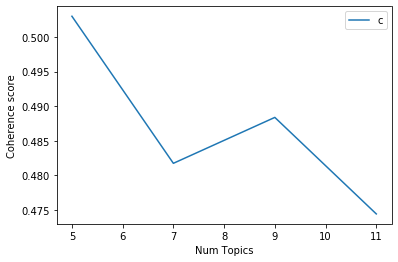

In [11]:
# Show graph

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [13]:
# # Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.503
Num Topics = 7  has Coherence Value of 0.4818
Num Topics = 9  has Coherence Value of 0.4884
Num Topics = 11  has Coherence Value of 0.4745


In [23]:

# now using mallet
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics= 5, id2word=id2word)

# Show Topics
print(ldamallet.print_topics(num_words=10))

[(0, '0.032*"stop" + 0.031*"long" + 0.024*"clean" + 0.021*"craving" + 0.018*"stay" + 0.018*"detox" + 0.017*"hard" + 0.017*"start" + 0.015*"bad" + 0.015*"clinic"'), (1, '0.093*"life" + 0.033*"give" + 0.028*"back" + 0.027*"save" + 0.027*"start" + 0.022*"change" + 0.019*"live" + 0.018*"miracle" + 0.016*"program" + 0.016*"free"'), (2, '0.069*"feel" + 0.033*"dose" + 0.032*"bad" + 0.019*"experience" + 0.018*"sleep" + 0.017*"sick" + 0.017*"start" + 0.014*"normal" + 0.014*"switch" + 0.012*"horrible"'), (3, '0.061*"doctor" + 0.044*"work" + 0.029*"good" + 0.026*"problem" + 0.020*"high" + 0.018*"prescribe" + 0.015*"insurance" + 0.014*"great" + 0.012*"pay" + 0.011*"money"'), (4, '0.052*"work" + 0.026*"side_effect" + 0.021*"patch" + 0.021*"give" + 0.020*"chronic" + 0.019*"relief" + 0.017*"severe" + 0.015*"put" + 0.013*"control" + 0.013*"back"')]


In [24]:
# Select the model and print the topics
optimal_model = ldamallet #model_list[0]
model_topics = optimal_model.show_topics(formatted=True)
print(optimal_model.print_topics(num_words=10))

[(0, '0.032*"stop" + 0.031*"long" + 0.024*"clean" + 0.021*"craving" + 0.018*"stay" + 0.018*"detox" + 0.017*"hard" + 0.017*"start" + 0.015*"bad" + 0.015*"clinic"'), (1, '0.093*"life" + 0.033*"give" + 0.028*"back" + 0.027*"save" + 0.027*"start" + 0.022*"change" + 0.019*"live" + 0.018*"miracle" + 0.016*"program" + 0.016*"free"'), (2, '0.069*"feel" + 0.033*"dose" + 0.032*"bad" + 0.019*"experience" + 0.018*"sleep" + 0.017*"sick" + 0.017*"start" + 0.014*"normal" + 0.014*"switch" + 0.012*"horrible"'), (3, '0.061*"doctor" + 0.044*"work" + 0.029*"good" + 0.026*"problem" + 0.020*"high" + 0.018*"prescribe" + 0.015*"insurance" + 0.014*"great" + 0.012*"pay" + 0.011*"money"'), (4, '0.052*"work" + 0.026*"side_effect" + 0.021*"patch" + 0.021*"give" + 0.020*"chronic" + 0.019*"relief" + 0.017*"severe" + 0.015*"put" + 0.013*"control" + 0.013*"back"')]


In [25]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

In [26]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [27]:
df_result = pd.DataFrame()
df_result['comment'] = data
df_result['Effectiveness'] = allData['Effectiveness']
df_result['Duration of Treatment'] = allData['Duration of Treatment']
df_result['Topic'] = df_dominant_topic['Dominant_Topic'].astype(int)
df_result

,comment,Effectiveness,Duration of Treatment,Topic
0,It saved my life in 2006 but I have been on it...,1,5,3
1,the same lever all the time.I feel good !,1,1,2
2,I6t changed my life. I could not manage othe...,1,3,4
3,The experience I write about is not my own. I ...,0,4,3
4,I have been an addict for 20 years. I have tri...,1,5,3
...,...,...,...,...
4043,You have to be very careful taking this drug! ...,1,5,0
4044,"You know, nothing in life is perfect..and as a...",1,3,1
4045,Zubsolv is a miracle drug. I have been abusing...,1,0,2
4046,Zubsolv works for me,1,4,4


In [31]:

df_dominant_topic
df_result.to_excel('/Users/sammie/JMIR_p1/topics7.xlsx', index=False)
df_result.to_excel('/Users/sammie/JMIR_p1/webMD_Drugs_Nov.xlsx', index=False, encoding='utf8')

In [29]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]



# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"doctor, work, good, problem, high, prescribe, ...",882.0,0.2179
1.0,2.0,"feel, dose, bad, experience, sleep, sick, star...",841.0,0.2078
2.0,4.0,"work, side_effect, patch, give, chronic, relie...",792.0,0.1957
3.0,3.0,"doctor, work, good, problem, high, prescribe, ...",661.0,0.1633
4.0,3.0,"doctor, work, good, problem, high, prescribe, ...",872.0,0.2154
...,...,...,...,...
4043.0,0.0,"stop, long, clean, craving, stay, detox, hard,...",NaN,NaN
4044.0,1.0,"life, give, back, save, start, change, live, m...",NaN,NaN
4045.0,2.0,"feel, dose, bad, experience, sleep, sick, star...",NaN,NaN
4046.0,4.0,"work, side_effect, patch, give, chronic, relie...",NaN,NaN


IndexError: index 5 is out of bounds for axis 0 with size 5

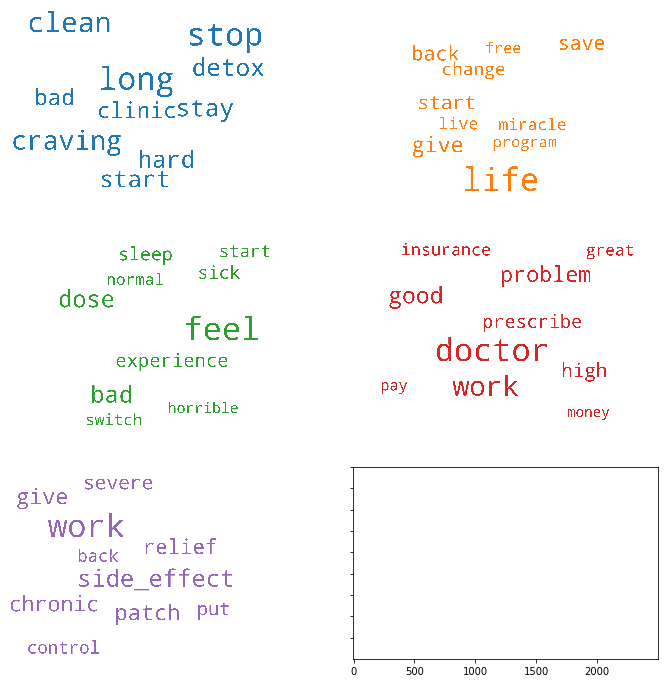

In [30]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

# topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(12,12), sharex=True, sharey=True)
tList=[0,1,2,3,4,5]
topicList=['','','','','','']
# tLits =[1]
# tLits = [24,25,26,27]

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic = optimal_model.show_topic(tList[i])
    topic_words = dict(topic)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().set_title(topicList[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

plt.savefig(r'/Users/sammie/Documents/CS_Courses/thesis/drugsWebsiteData/'
            'independent_study_2019/Topic_Series_1.png', dpi = 360 )


In [ ]:
plt.savefig('/Users/sammie/Desktop/cloud1.png')

In [170]:
topics = optimal_model.show_topic(1)
print(topics)

[('dose', 0.040548305015185096), ('side_effect', 0.031191003857834687), ('high', 0.02446031355167036), ('detox', 0.02183370270048428), ('clinic', 0.017401296889107774), ('abuse', 0.016662562587211688), ('patient', 0.014528441270623), ('taper', 0.013871788557826479), ('effect', 0.01272264631043257), ('daily', 0.01091685135024214)]
